# Space-ship Titanic Kaggle Work

In [1]:
import os
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'

# basic modules
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier

***Read Data***

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

data_path = './data/'
train = 'train.csv'

train_file = os.path.join(data_path,train)

In [3]:
df = pd.read_csv(train_file)

## Begin Exploratory Data Analysis

In [4]:
print(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Basic Column Data Extraction

### PassengerId Column
**Engineer 'PassengerId' column**:
- The 'PassengerId' column is of the form: gggg_pp where gggg indicates the group they are traveling with and pp is their number within the group. By extracting these values we can create meaning from this column and hopefully use it to impute missing values later.

In [5]:
df['GroupId'] = df['PassengerId'].apply(lambda x: x.split("_")[0]).astype(int)
df['PersonId'] = df['PassengerId'].apply(lambda x: x.split("_")[1]).astype(int)
df.drop(columns=['PassengerId'], inplace=True)
df.head(2)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,PersonId
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1


### 'Cabin' Column
**Engineer the 'Cabin' column:**
- The 'Cabin' column is of the form deck/num/side. We can engineer this feature to extract meaningful info for the column.

In [6]:
df['Deck'] = df[df['Cabin'].notna()]['Cabin'].str.split('/').apply(lambda x: x[0])
df['Num'] = df[df['Cabin'].notna()]['Cabin'].str.split('/').apply(lambda x: x[1])
df['Side'] = df[df['Cabin'].notna()]['Cabin'].str.split('/').apply(lambda x: x[2])
df.drop(columns=['Cabin'],inplace=True)
df.head(2)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,PersonId,Deck,Num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1,F,0,S


### Name Column
**First Name and Last Name extraction**
- By extracting the first and last names, we can hopefully use this data to impute missing features. Namely, we can hopefully use last names to impute missing data.

In [7]:
df['FirstName'] = df[df['Name'].notna()]['Name'].str.split(' ').apply(lambda x: x[0].strip())
df['LastName'] = df[df['Name'].notna()]['Name'].str.split(' ').apply(lambda x: x[1].strip())
df.drop(columns=['Name'], inplace = True)
df.head(2)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,PersonId,Deck,Num,Side,FirstName,LastName
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,1,B,0,P,Maham,Ofracculy
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,1,F,0,S,Juanna,Vines


## Imputation: Missing Home Planets

**Missing home planet imputation**
- Imputation of missing home planets might be relatively simple to do. We might only have to consider shared attribtues among groups we are confident about like shared last names, group ids and home planets.
- Before we attempt to impute missing home-planets, we should have some confidence that these missing home planets are in-fact MCAR, so we will run a chi-2 test on the home planets.

In [8]:
contingency = pd.crosstab(df['HomePlanet'], df['Transported'], dropna=False)

print(contingency)

c, p, dof, expected = chi2_contingency(contingency)

print(c,p,dof)
print(expected)

Transported  False  True 
HomePlanet               
Earth         2651   1951
Europa         727   1404
Mars           839    920
NaN             98    103
324.96723663979583 3.9214919240932375e-70 3
[[2284.32416887 2317.67583113]
 [1057.77809732 1073.22190268]
 [ 873.12607845  885.87392155]
 [  99.77165535  101.22834465]]


Observation
- We can see that the frequency table for the missing home planet and the chi-2 expected frequency values are nearly the same, which indicates that there isn't an apparent association between a home planet being missing and being successfully transported or not. This hints at homeplanet being missing being an MCAR value, which means we will proceed with imputation of this feature.

### Impute missing home planets (High-Confidence) (Family members)
Missing home planet will be imputed for groups of people such that:
- They all have the same GroupID
- All have the same LastName
- All come from the same planet
- All going to the same destination

The home planet imputed will be the groups home planet

In [9]:
def get_groups_0(df) -> list:
  groups = []
  group_ids = df['GroupId'].unique().tolist()
  for group_id in group_ids:

    # get sub-dataframe based off of group id
    group_df = df[df['GroupId'] == group_id]

    has_missing_planet = group_df['HomePlanet'].isna().any()
    has_one_distinct_home = group_df['HomePlanet'].dropna().nunique() == 1
    has_one_distinct_destination = group_df['Destination'].dropna().nunique() == 1
    has_one_distinct_last_name = group_df['LastName'].dropna().nunique() == 1
    
    if (
        has_missing_planet and
        has_one_distinct_last_name and
        has_one_distinct_home and
        has_one_distinct_destination        
    ):
        groups.append(group_df)
      
  return groups

group_dfs = get_groups_0(df)
print(f"number of samples where home planet is missing:{df['HomePlanet'].isna().sum()}")
print(f"Number of groups: {len(group_dfs)}")

while group_dfs:
  group_df = group_dfs.pop()
  home_planets = group_df['HomePlanet'].dropna().unique()
  if len(home_planets) > 1:
    raise ValueError(home_planets)
  home_planet = home_planets[0]
  df.loc[group_df['HomePlanet'].isna().index, 'HomePlanet'] = home_planet
  
print(f"number of samples where home planet is missing:{df['HomePlanet'].isna().sum()}")

number of samples where home planet is missing:201
Number of groups: 36
number of samples where home planet is missing:165


### Impute missing home planets (Medium Confidence) (Family members from same planet)
**Imput Home Planets by:**
  - Groups where GroupID are all the same
  - Groups where LastName are all the same
  - There is only one unique type of home planet in the group of people
  
Update missing home planets with the groups single distinct non-na home planet

In [10]:
def get_groups_1(df):
    groups =[]
    group_ids = df['GroupId'].unique().tolist()
    for group_id in group_ids:
        group_df = df[df['GroupId'] == group_id]
        
        missing_home_planet = group_df['HomePlanet'].isna().any()
        one_distinct_last_name = group_df['LastName'].dropna().nunique() == 1
        one_distinct_home_planet = group_df['HomePlanet'].dropna().nunique() == 1
        
        if (
            missing_home_planet and
            one_distinct_last_name and
            one_distinct_home_planet
        ):
            groups.append(group_df)
            
    return groups

group_dfs = get_groups_1(df)

print(f"number of samples with missing home planet: {df['HomePlanet'].isna().sum()}")
print("groups:",len(group_dfs))

while group_dfs:
    group_df = group_dfs.pop()
    
    planets = group_df['HomePlanet'].dropna().unique().tolist()
    
    if len(planets) != 1:
        raise ValueError("HUH")

    df.loc[group_df['HomePlanet'].isna().index, 'HomePlanet'] = planets[0]    
    
print(f'samples remaining with missing home planets: {df["HomePlanet"].isna().sum()}')

number of samples with missing home planet: 165
groups: 31
samples remaining with missing home planets: 133


## Imputation: Missing destination planets
- Same process as with missing home planets essentially

In [11]:
contingency = pd.crosstab(df['Destination'], df['Transported'], dropna=False)

print(contingency)

c, p, dof, expected = chi2_contingency(contingency)

print(c,p,dof)
print(expected)

Transported    False  True 
Destination                
55 Cancri e      702   1098
PSO J318.5-22    395    401
TRAPPIST-1e     3128   2787
NaN               90     92
106.39488238823832 6.547434028958798e-23 3
[[ 893.47751064  906.52248936]
 [ 395.11561026  400.88438974]
 [2936.06637524 2978.93362476]
 [  90.34050385   91.65949615]]


Obvservation:
- Similar case as the home planetplanet feature. These missing destination planets appear to be MCAR due to the low assocation. We will impute the missing values.

Action
- For Groups of GroupId such that:
    - There is at least one person in the group with a missing destination planet
    - All people in the group have the same last name (family)
    - ALl people in the group have the same home planet
    - ALl people in the group have the same destination (excluding the missing destinations)
Fill the missing destination

In [12]:
def get_group_2(df):
  groups = []
  group_ids = df['GroupId'].unique().tolist()
    
  for group_id in group_ids:
    
    group_df = df[df['GroupId'] == group_id]
    
    at_least_one_missing_destination_planet = group_df['Destination'].isna().any()
    only_one_distinct_destination_planet = group_df['Destination'].dropna().nunique() == 1    
    only_one_distinct_home_planet = group_df['HomePlanet'].dropna().nunique() == 1
    only_one_distinct_last_name = group_df['LastName'].dropna().nunique() == 1
    
    if (
        at_least_one_missing_destination_planet and
        only_one_distinct_home_planet and
        only_one_distinct_destination_planet and
        only_one_distinct_last_name
    ):
        groups.append(group_df)
    
  return groups

print('number of remaining samples where destination is missing:',df['Destination'].isna().sum())

groups = get_group_2(df)
print(f'number of groups found: {len(groups)}')

while groups:
    group_df = groups.pop()
    destination_planets = group_df['Destination'].dropna().unique().tolist()
    if len(destination_planets) != 1:
        raise ValueError(len(destination_planets))
    df.loc[group_df['Destination'].isna().index, 'Destination'] = destination_planets[0]
    
print('number of remaining samples where destination is missing after imputation:',df['Destination'].isna().sum())


number of remaining samples where destination is missing: 182
number of groups found: 48
number of remaining samples where destination is missing after imputation: 134


## Feature Importance
To determine which categorical features to impute next, lets attempt to rank our categorical features importance with respect to the target using regression.

In [13]:
display(df.info())
display(df.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8560 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8559 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   bool   
 11  GroupId       8693 non-null   int64  
 12  PersonId      8693 non-null   int64  
 13  Deck          8494 non-null   object 
 14  Num           8494 non-null   object 
 15  Side          8494 non-null   object 
 16  FirstName     8493 non-null   object 
 17  LastName      8493 non-null   object 
dtypes: bool(1), float64(6), int6

None

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,PersonId,Deck,Num,Side,FirstName,LastName
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,1,B,0,P,Maham,Ofracculy
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,1,F,0,S,Juanna,Vines


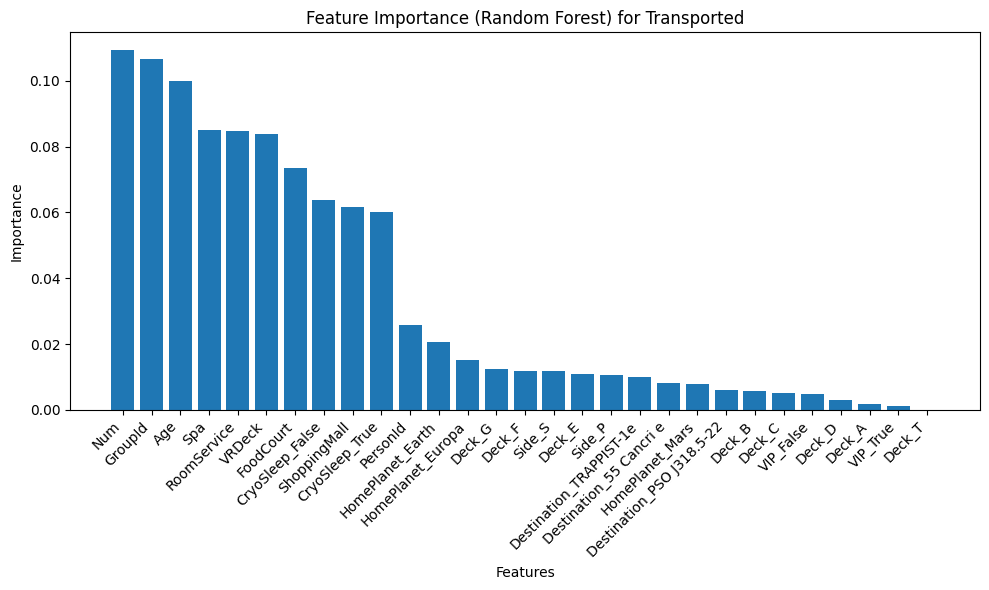

In [14]:
# Assuming your data is in a DataFrame called 'df'
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']  # Replace with your categorical feature names
continuous_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupId', 'Num', 'PersonId']
target_feature = 'Transported'  # Replace with the name of your target variable

temp_df = df[categorical_features + continuous_features + [target_feature]]

temp_df = pd.get_dummies(temp_df, columns=categorical_features)

X = temp_df.drop(columns=[target_feature])
y = temp_df[target_feature]

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X, y)

importance_df = pd.DataFrame({'Feature': rf_classifier.feature_names_in_, 'Importance': rf_classifier.feature_importances_})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance (Random Forest) for Transported')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Observations**:
- Continuous features have the largest impact on the target.
- Unexpectedly, 'Num', and 'GroupId' have a large impact on the target.
- The categorical feature that has the largest impact on the target is CryoSleep.

## Cryosleep Analysis
- Let's try to glean information about cryosleep for imputation.

In [15]:
did_cryo = df[df['CryoSleep'] == True]
no_cryo = df[df['CryoSleep'] == False]

spending_money_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
display("DID CRYO")
display(did_cryo.head())
display(did_cryo[spending_money_cols].describe())
display('-----------')
display('NO CRYO')
display(no_cryo.head())
display(no_cryo[spending_money_cols].describe())

'DID CRYO'

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,PersonId,Deck,Num,Side,FirstName,LastName
7,Earth,True,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,True,6,2,G,0,S,Candra,Jacostaffey
9,Europa,True,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,True,8,1,B,1,P,Erraiam,Flatic
10,Europa,True,TRAPPIST-1e,34.0,False,0.0,0.0,NaN,0.0,0.0,True,8,2,B,1,P,Altardr,Flatic
18,Mars,True,TRAPPIST-1e,45.0,False,0.0,0.0,0.0,0.0,0.0,True,16,1,F,5,P,Alus,Upead
21,Earth,True,TRAPPIST-1e,1.0,False,0.0,0.0,0.0,0.0,0.0,False,20,1,E,0,S,Almary,Brantuarez


,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,2969.0,2967.0,2941.0,2972.0,2975.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


'-----------'

'NO CRYO'

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,PersonId,Deck,Num,Side,FirstName,LastName
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,1,B,0,P,Maham,Ofracculy
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,1,F,0,S,Juanna,Vines
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3,1,A,0,S,Altark,Susent
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3,2,A,0,S,Solam,Susent
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4,1,F,1,S,Willy,Santantines


,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,5328.000000,5329.000000,5335.000000,5326.000000,5320.000000
mean,350.146772,713.004316,270.586504,486.092940,475.716165
std,803.080320,1970.547985,741.756155,1396.233751,1404.174304
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,5.000000,2.000000,7.000000,4.000000
75%,390.250000,537.000000,242.000000,354.750000,356.000000
max,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


**Observations**
- We can see that people who do cryo never spend any money. This can help us impute missing cryo data and missing money data. 
- We can see that people who did CRYO and were VIP were all from Europa Home planet. We can quickly impute this

## Imputation: CryoSleep and Shopping Data
- We discussed earlier that shopping data is a good proxy for determining if someone did cryosleep or not. Lets begin by imputing shopping data.

***Imputation:***
- If someone did cryosleep, we know they didn't spend any money. So, for any sample where shopping data is missing, if the person did cryosleep, we will impute a 0.0.
- If cryosleep data is missing, and we see the person spent money, we know they didn't do cryosleep. That is, if a person spent money and cryosleep is missing, we will fill a False.df[(df['CryoSleep'] == True) & (df[spending_money_cols].sum(axis=1))]spending_money_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


In [16]:
spending_money_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [17]:
df[(df['CryoSleep'] == True) & (df[spending_money_cols].sum(axis=1) > 0.0)]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,PersonId,Deck,Num,Side,FirstName,LastName


In [18]:
mask = df[(df['CryoSleep'] == True) & (df[spending_money_cols].isna().any(axis=1))].index
df.loc[mask, spending_money_cols] = 0.0

mask = df[(df['CryoSleep'].isna()) & (df[spending_money_cols].sum(axis=1) > 0.0)].index
df.loc[mask, 'CryoSleep'] = False

df[(df['CryoSleep'] == True) & (df[spending_money_cols].sum(axis=1) > 0.0)]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,PersonId,Deck,Num,Side,FirstName,LastName


### Feature Engineering: TotalSpent and SpentMoney column
- Spending money appears to be a good proxy for certain information. We can create a simple continuous feature that simply tells how much money, if any, was spent.

In [19]:
df['TotalSpent'] = df[spending_money_cols].sum(axis=1)
df.loc[df[spending_money_cols].sum(axis=1) > 0, 'SpentMoney'] = True
df.loc[(df[spending_money_cols].notna().all(axis=1)) & (df[spending_money_cols].sum(axis=1) == 0), 'SpentMoney'] = False
df[df[spending_money_cols].isna().any(axis=1) & (df['TotalSpent'] == 0)].head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,PersonId,Deck,Num,Side,FirstName,LastName,TotalSpent,SpentMoney
111,Mars,NaN,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,NaN,True,115,1,F,24,P,Rohs,Pead,0.0,NaN
574,Mars,False,TRAPPIST-1e,4.0,False,0.0,NaN,0.0,0.0,0.0,True,599,2,F,124,P,Bases,Crité,0.0,NaN
590,Earth,False,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,NaN,0.0,True,614,1,G,91,S,Feline,Carterson,0.0,NaN
686,Earth,False,NaN,12.0,False,0.0,0.0,NaN,0.0,0.0,True,714,3,G,109,P,Sony,Rilley,0.0,NaN
768,Mars,False,TRAPPIST-1e,10.0,False,0.0,0.0,0.0,0.0,NaN,True,809,1,F,151,S,Oaters,Meake,0.0,NaN


## Feature Importance Round II
- We've imputed some data and engineered some new features. Lets check out the new feature importance.

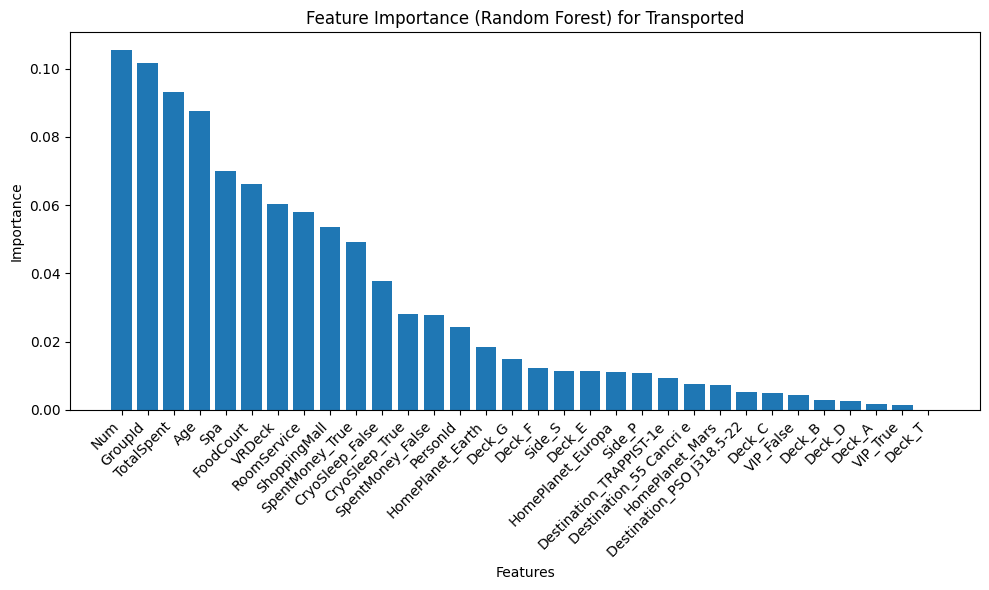

Missing features


HomePlanet      133
CryoSleep        98
Destination     134
Age             179
VIP             203
RoomService     113
FoodCourt       113
ShoppingMall    112
Spa             118
VRDeck          126
Transported       0
GroupId           0
PersonId          0
Deck            199
Num             199
Side            199
FirstName       200
LastName        200
TotalSpent        0
SpentMoney       59
dtype: int64

7271


In [20]:
# Assuming your data is in a DataFrame called 'df'
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'SpentMoney']  # Replace with your categorical feature names
continuous_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupId', 'Num', 'PersonId', 'TotalSpent']
target_feature = 'Transported'  # Replace with the name of your target variable

temp_df = df[categorical_features + continuous_features + [target_feature]]

temp_df = pd.get_dummies(temp_df, columns=categorical_features)

X = temp_df.drop(columns=[target_feature])
y = temp_df[target_feature]

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=1337)
rf_classifier.fit(X, y)

importance_df = pd.DataFrame({'Feature': rf_classifier.feature_names_in_, 'Importance': rf_classifier.feature_importances_})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance (Random Forest) for Transported')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Missing features")
display(df.isna().sum())
print(len(df[categorical_features + continuous_features + [target_feature]].dropna()))

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8560 non-null   object 
 1   CryoSleep     8595 non-null   object 
 2   Destination   8559 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8580 non-null   float64
 6   FoodCourt     8580 non-null   float64
 7   ShoppingMall  8581 non-null   float64
 8   Spa           8575 non-null   float64
 9   VRDeck        8567 non-null   float64
 10  Transported   8693 non-null   bool   
 11  GroupId       8693 non-null   int64  
 12  PersonId      8693 non-null   int64  
 13  Deck          8494 non-null   object 
 14  Num           8494 non-null   object 
 15  Side          8494 non-null   object 
 16  FirstName     8493 non-null   object 
 17  LastName      8493 non-null   object 
 18  TotalSpent    8693 non-null 

In [45]:
!python3 main.py

Index(['CryoSleep', 'VIP', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'GroupId', 'PersonId', 'Num', 'Transported',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
       'Deck_F', 'Deck_G', 'Deck_T', 'Side_S'],
      dtype='object')
       Age  RoomService  FoodCourt  ...  GroupId  PersonId   Num
0     39.0          0.0        0.0  ...        1         1     0
1     24.0        109.0        9.0  ...        2         1     0
2     58.0         43.0     3576.0  ...        3         1     0
3     33.0          0.0     1283.0  ...        3         2     0
4     16.0        303.0       70.0  ...        4         1     1
...    ...          ...        ...  ...      ...       ...   ...
8688  41.0          0.0     6819.0  ...     9276         1    98
8689  18.0          0.0        0.0  ...     9278         1 

In [ ]:
# df = impute_HomePlanet_HighConfidence(df)
# test 1 - 0.7792494481236203

# df = impute_HomePlanet_HighConfidence(df)
# df = impute_HomePlanet_MediumConfidence(df)
# test 2 - 0.7801328778748132


# df = impute_HomePlanet_HighConfidence(df)
# df = impute_HomePlanet_MediumConfidence(df)
# df = impute_Destination_LowConfidence(df)
# - 0.7806857151350812


# df = impute_HomePlanet_HighConfidence(df)
# df = impute_HomePlanet_MediumConfidence(df)
# df = impute_Destination_LowConfidence(df)
# df = impute_VIPEarth_LowConfidence(df)
# - 0.7768511861969806


# df = impute_HomePlanet_HighConfidence(df)
# df = impute_HomePlanet_MediumConfidence(df)
# df = impute_Destination_LowConfidence(df)
# df = impute_SpendingMoney_HighConfidence(df)
# 0.7794131006570709


# df = impute_HomePlanet_HighConfidence(df)
# df = impute_HomePlanet_MediumConfidence(df)
# df = impute_Destination_LowConfidence(df)
# df = impute_VIPEarth_LowConfidence(df)
# df = impute_SpendingMoney_HighConfidence(df)
# 0.7747616954296006